# Lesson 16 - Comparison of Regression Techniques

### The following topics are discussed in this notebook:
* Simple Linear Regression (SLR), Lasso Regression, KNN Regression
* Normalization
* Model Selection


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

The cell below creates a dataset, with features stored in `X` and continuous labels stored in `y`.

In [2]:
%run -i examples/example13.py

In [3]:
print(X.shape)
print(y.shape)

(20000, 10)
(20000,)


We split the dataset into subsets for using in training, validation, and testing. We will use an 80/10/10 split.

In [4]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=1)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(16000,)
(2000,)
(2000,)


## Simple Linear Regression Model

We will start by create a simple linear regression model using all 10 features. There are no hyperparameters to tune in SLR, so we will not need to use the validation set. 

In [5]:
slr_mod = LinearRegression()
slr_mod.fit(X_train, y_train)

print('--- SLR Model ---')
print('Training r2:', slr_mod.score(X_train, y_train))
print('Testing r2: ', slr_mod.score(X_test, y_test))

--- SLR Model ---
Training r2: 0.612463515906
Testing r2:  0.610629456631


In [6]:
print(slr_mod.intercept_)
print(slr_mod.coef_)

-951.36641618
[ -3.06361093e-01  -1.30722175e+00  -9.96000617e-03   1.02967747e+02
  -2.82257431e-02  -1.93279017e-02   1.63978406e+01   5.00989532e+00
   7.41183027e-03  -3.85488226e-02]


## Lasso Regression (Linear Regression with Regularization)

We will now use lasso regression to perform regularization and model selection. We need to use the validation set to select an appropriate value for the hyperparameter $\alpha$.

When applying the lasso regression model, it is usually a good idea to normalize your features. This can be done by setting `normalize=True` when creating an instance of the `Lasso` class. 

Normalization is performed by applying the transformation to $\Large w^{(k)}_i = \frac{x^{(k)}_i - min(x^{(k)})}{max(x^{(k)}) - min(x^{(k)})}$ to each observation. 

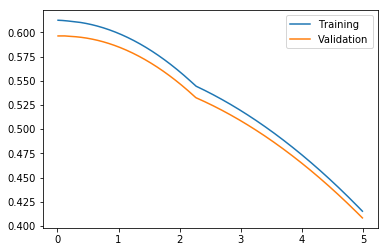

In [7]:
train_scores = []
val_scores = []

alphas = np.arange(.01,5,.01)

for a in alphas:
    temp_mod = Lasso(alpha=a, normalize=True)
    temp_mod.fit(X_train, y_train)
    train_scores.append(temp_mod.score(X_train, y_train))
    val_scores.append(temp_mod.score(X_val, y_val))
    
plt.close()
plt.plot(alphas, train_scores, label = "Training")
plt.plot(alphas, val_scores, label = "Validation")
plt.legend() # x axis is alpha, y axis for scores
plt.show()

The validation curve is at its highest at or near $\alpha = 0$, indicating that there is not a strong need for regularization. We will still consider a couple of models with small values of alpha, to try to get a sense as to which features are most relevant to the model. 

In [8]:
lasso_mod = Lasso(alpha=0.13, normalize=True)
lasso_mod.fit(X_train, y_train)

print('--- Lasso Model ---')
print('Training r2:', lasso_mod.score(X_train, y_train))
print('Testing r2: ', lasso_mod.score(X_test, y_test))

print()
print('--- Coefficients ---')
print(lasso_mod.intercept_)
print(lasso_mod.coef_)

--- Lasso Model ---
Training r2: 0.611945011982
Testing r2:  0.611016875785

--- Coefficients ---
-928.491595593
[  -0.           -0.           -0.          101.52517386   -0.           -0.
    4.82892288    4.71827069    0.           -0.        ]


It appears that features 3, 6, and 7 are most relevant to the model. 

## Simple Linear Regression with Selected Variables


The lasso model has suggested that features 3, 6, and 7 are the ones most useful for predicting values of `y`. We will now create an SLR model using only these variables, and will compare the results with what we obtained from SLR using all 10 features. 

Note that removing features from the dataset, will **always** reduce the **training $r^2$** value.

In [9]:
X_train_sel = X_train[:,[3,6,7]]
X_val_sel = X_val[:,[3,6,7]] # validation set
X_test_sel = X_test[:,[3,6,7]]

In [10]:
slr_mod_sel = LinearRegression()
slr_mod_sel.fit(X_train_sel, y_train)

print('--- SLR w/ Selected ---')
print('Training r2:', slr_mod_sel.score(X_train_sel, y_train))
print('Testing r2: ', slr_mod_sel.score(X_test_sel, y_test))

print()
print('--- Coefficients ---')
print(slr_mod_sel.intercept_)
print(slr_mod_sel.coef_)

--- SLR w/ Selected ---
Training r2: 0.612281771826
Testing r2:  0.610949973156

--- Coefficients ---
-1015.29221627
[ 102.96723061   16.3756616     5.0081231 ]


When restricting our SLR to only three features, we saw a slight drop in training $r^2$ (as expected) and a slight increase in testing $r^2$. Although, these changes are not particularly significant, we are likely to prefer the model with only three features, as it is simpler and is less likely to include features that are unrelated to the label `y`.

## KNN on Original Data

We now turn our attention to applying a KNN regression algorithm to the data. We will need to use the validation set to select an appropriate value for the hyperparameter K. 

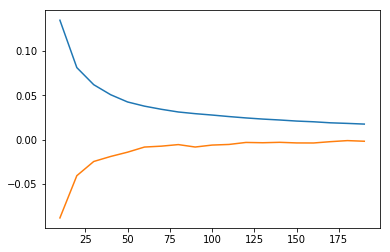

In [13]:
train_scores = []
val_scores = []

rng = np.arange(10,200,10)

for K in rng:
    temp_mod = KNeighborsRegressor(K, algorithm="brute")
    temp_mod.fit(X_train, y_train)
    #train_scores.append(temp_mod.score(X_train, y_train))
    val_scores.append(temp_mod.score(X_val, y_val))
    
plt.close()
#plt.plot(rng, train_scores)
plt.plot(rng, val_scores)
plt.show()

The KNN model did **VERY** poorly. The $r^2$ values are negative. This means that the model not only fails to explain any of the variance in the $y$ values, it actually introduces more noise into the system. 

To get a sense as the why this might be, lets take a look at how the features in our dataset are distributed. 

In [14]:
print('Column Minima')
print(np.apply_along_axis(arr=X, axis=0, func1d=np.min )) #apply function, np.min to all column (axis=0) to the data set (arr=X)

print('\n' + 'Column Maxima')
print(np.apply_along_axis(arr=X, axis=0, func1d=np.max ))

print('\n' + 'Column Means')
print(np.apply_along_axis(arr=X, axis=0, func1d=np.mean ))

Column Minima
[ 0.00471292  0.00072284  0.00518469  0.00091884  0.029888    0.03707162
  0.00027467  0.00285963  0.04967624  0.02427785]

Column Maxima
[   99.99000961     9.99990284   499.88570684    39.99857489  1999.68991232
   999.79954741     4.99987022   199.98280391  1999.7856744    499.94692304]

Column Means
[   50.12768548     4.97013792   249.98066853    19.94940825   998.21675379
   502.63251977     2.49417533   100.78694324  1000.98803982   247.6168478 ]


The issue with our KNN model was that the scale of the features varied wildly from one feature to the next. We can fix this by applying normalization. We will now normalize each feature according to the formula $\Large w^{(k)}_i = \frac{x^{(k)}_i - min(x^{(k)})}{max(x^{(k)}) - min(x^{(k)})}$.

## Scaling Data

Scikit-learn provides a function called `MaxAbsScaler` for performing normalization.

In [15]:
from sklearn.preprocessing import scale, MaxAbsScaler

In [16]:
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

Let's take a look at the distribution for our normalized features. 

In [17]:
print('Column Minima')
print(np.apply_along_axis(arr=X_scaled, axis=0, func1d=np.min ))

print('\n' + 'Column Maxima')
print(np.apply_along_axis(arr=X_scaled, axis=0, func1d=np.max ))

print('\n' + 'Column Means')
print(np.apply_along_axis(arr=X_scaled, axis=0, func1d=np.mean ))

Column Minima
[  4.71338933e-05   7.22844894e-05   1.03717530e-05   2.29718565e-05
   1.49463196e-05   3.70790520e-05   5.49344848e-05   1.42993968e-05
   2.48407833e-05   4.85608583e-05]

Column Maxima
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]

Column Means
[ 0.50132694  0.49701862  0.50007565  0.49875298  0.49918577  0.50273329
  0.49884801  0.50397805  0.50054766  0.49528627]


We need to create training, validation, and testing sets for our new scaled dataset. 

In [18]:
sX_train, sX_holdout, sy_train, sy_holdout = train_test_split(X_scaled, y, test_size=0.2, random_state=1)
sX_val, sX_test, sy_val, sy_test = train_test_split(sX_holdout, sy_holdout, test_size=0.5, random_state=1)

print(sy_train.shape)
print(sy_val.shape)
print(sy_test.shape)

(16000,)
(2000,)
(2000,)


## KNN on Scaled Data

We now return to the task of applying a KNN algorithm, this time on the scaled dataset. As before, we need to use the validation set to select an appropriate *K*.

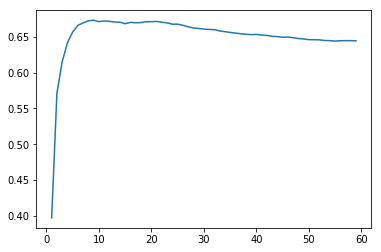

In [19]:
train_scores = []
val_scores = []

rng = range(1,60)

for K in rng:
    #print(K)
    temp_mod = KNeighborsRegressor(K, algorithm="brute")
    temp_mod.fit(sX_train, sy_train)
    #train_scores.append(temp_mod.score(sX_train, sy_train))
    val_scores.append(temp_mod.score(sX_val, y_val))
    
plt.close()
#plt.plot(rng, train_scores)
plt.plot(rng, val_scores)
plt.show()

It appears that any *K* in the range from about 8 to 20 would be good. 

In [20]:
knn_mod = KNeighborsRegressor(8)
knn_mod.fit(sX_train, y_train)


print('--- KNN Model (K=8) ---')
print('Training r2:', knn_mod.score(sX_train, y_train))
print('Testing r2: ', knn_mod.score(sX_test, y_test))


--- KNN Model (K=8) ---
Training r2: 0.732770432764
Testing r2:  0.663076739128


## KNN with Selected Features

Our lasso model from before suggested to us that features 3, 6, and 7 were the most relevant for the task of predicting `y`. Let's try applying the KNN algorithm to a dataset that includes only these three features.

In [21]:
sX_train_sel = sX_train[:,[3,6,7]]
sX_val_sel = sX_val[:,[3,6,7]]
sX_test_sel = sX_test[:,[3,6,7]]

We must select a value of *K*.

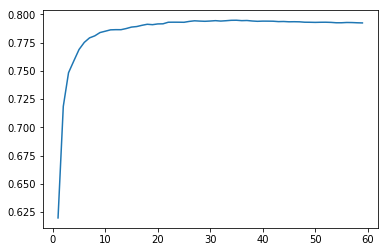

In [22]:
train_scores = []
val_scores = []

rng = range(1,60)

for K in rng:
    temp_mod = KNeighborsRegressor(K, algorithm="brute")
    temp_mod.fit(sX_train_sel, y_train)
    #train_scores.append(temp_mod.score(sX_train_sel, y_train))
    val_scores.append(temp_mod.score(sX_val_sel, y_val))
    
plt.close()
#plt.plot(rng, train_scores)
plt.plot(rng, val_scores)
plt.show()

In [23]:
knn_mod_sel = KNeighborsRegressor(30)
knn_mod_sel.fit(sX_train_sel, y_train)

print('--- KNN Model w/ Selected (K=20) ---')
print('Training r2:', knn_mod_sel.score(sX_train_sel, y_train))
print('Testing r2: ', knn_mod_sel.score(sX_test_sel, y_test))

--- KNN Model w/ Selected (K=20) ---
Training r2: 0.804030008311
Testing r2:  0.785819789235


## Polynomial Regression

We will now consider a SLR model that includes a (very specifically selected) set of polynomial features. 

In [24]:
Xpoly = np.array([x4*x8, x4**4, x7, x8]) # x4, x8 ... are in example10.py
Xpoly = Xpoly.transpose()
print(Xpoly.shape)

(20000, 4)


In [25]:
Xpoly_train, Xpoly_holdout, y_train, y_holdout = train_test_split(Xpoly, y, test_size=0.2, random_state=1)
Xpoly_val, Xpoly_test, y_val, y_test = train_test_split(Xpoly_holdout, y_holdout, test_size=0.5, random_state=1)

In [26]:
poly_mod = LinearRegression()
poly_mod.fit(Xpoly_train, y_train)

print('--- Polynomial Model ---')
print('Training r2:', poly_mod.score(Xpoly_train, y_train))
print('Testing r2: ', poly_mod.score(Xpoly_test, y_test))

print()
print('--- Coefficients ---')
print(poly_mod.intercept_)
print(poly_mod.coef_)

--- Polynomial Model ---
Training r2: 0.801614441373
Testing r2:  0.800197048357

--- Coefficients ---
10.7748594837
[  5.63551549e-03   2.00560252e-03   1.64566721e+01   4.93004677e+00]
